In [60]:
!pip install pandas numpy nltk gensim spacy

In [61]:
import pandas as pd
import nltk
import gensim
import spacy
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
%matplotlib inline
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def clean_text(my_text, language = "english"):
  # Tokenization
  tokens = [w.lower() for w in word_tokenize(my_text)]
  # Remove stopwords
  stop_words = set(stopwords.words(language))
  filtered_words = [w for w in tokens if w not in stop_words]
  # Remove special character
  filtered_words = [w for w in filtered_words if w.isalpha()]
  # Lemmatization
  lemmatized_words = [lemmatizer.lemmatize(w, "v") for w in filtered_words] # verbs
  lemmatized_words = [lemmatizer.lemmatize(w, "n")  for w in lemmatized_words] # nouns

  return(' '.join(lemmatized_words))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [62]:
# Read csv file
df = pd.read_csv('NikeProductDescriptions.csv')

# Filter the dataset
selected_subtitles = ["Men's Shoes", "Men's T-Shirt", "Women's Shoes", "Skate Shoes", "Older Kids' T-Shirt"]
df_filtered = df[df['Subtitle'].isin(selected_subtitles)]
shorts_df = df[df['Subtitle'].str.contains("Shorts", na=False)]
shorts_df.loc[:, 'Subtitle'] = "Shorts"
df_filtered = pd.concat([df_filtered, shorts_df])

# Clean Product description
df_filtered['cleaned_description'] = df_filtered['Product Description'].apply(lambda x: clean_text(str(x)))

# Print unique values in subtitle column.
print(df_filtered["Subtitle"].unique())

df.head(1)

["Men's Shoes" 'Skate Shoes' "Men's T-Shirt" "Women's Shoes"
 "Older Kids' T-Shirt" 'Shorts']


,Title,Subtitle,Product Description
0,Nike Air Force 1 '07,Men's Shoes,It doesn't get more legendary than this. Desig...


In [63]:
import pandas as pd

# Display general statistics of the DataFrame
df.describe(include='all')


,Title,Subtitle,Product Description
count,400,400,400
unique,254,228,400
top,Nike Sportswear,Women's Shoes,It doesn't get more legendary than this. Desig...
freq,41,34,1


# Bag of Words

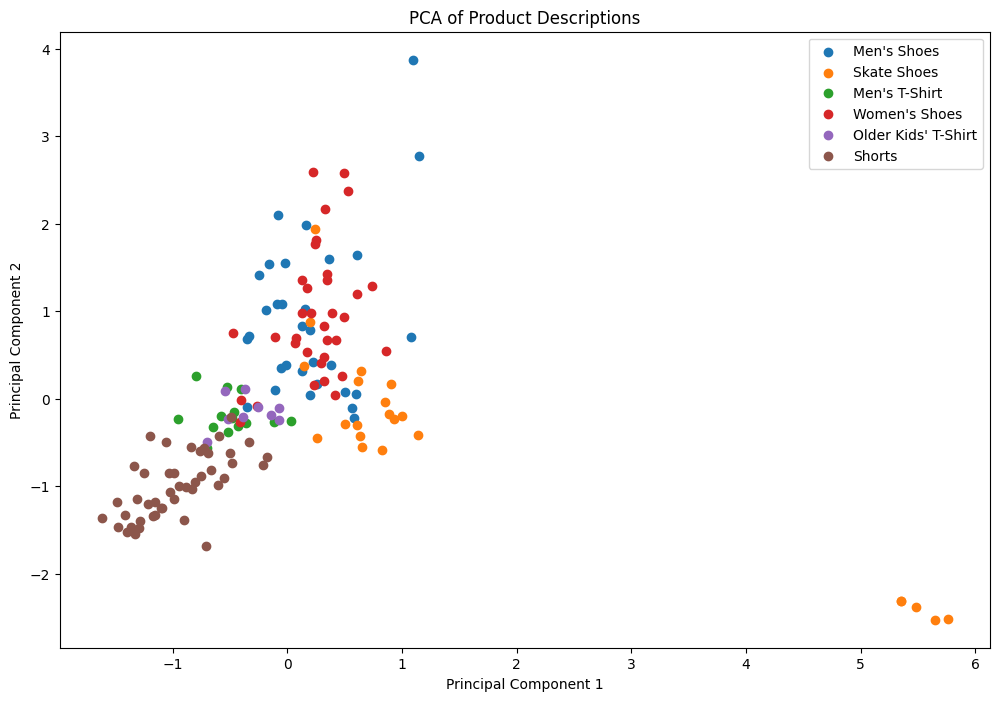

In [64]:
# Word Embedding - BOW

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer()


X = bow_vectorizer.fit_transform(df_filtered['cleaned_description'])
df_bow = pd.DataFrame(X.toarray(), columns=bow_vectorizer.get_feature_names_out(), index=df_filtered.index)

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_bow)

# Create a scatter plot of the PCA results, colored by 'Subtitle'
plt.figure(figsize=(12, 8))
for subtitle in df_filtered['Subtitle'].unique():
    subset = pca_result[df_filtered['Subtitle'] == subtitle]
    plt.scatter(subset[:, 0], subset[:, 1], label=subtitle)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Product Descriptions")
plt.legend()
plt.show()

# Term Frequency - Inverse Document Frequency

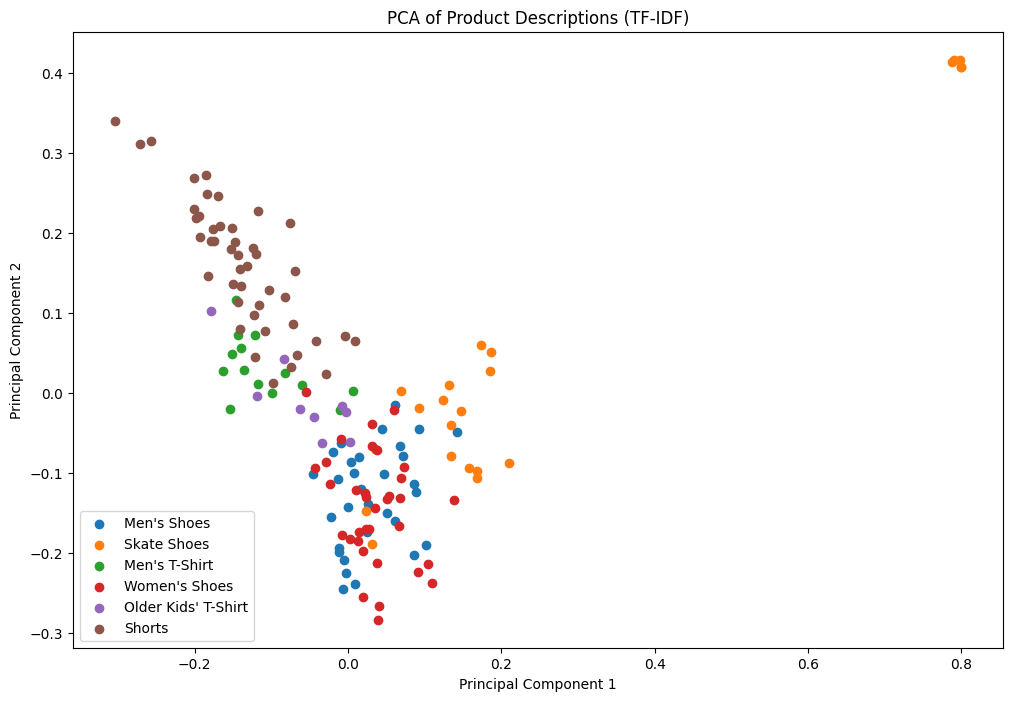

In [65]:
# prompt: Now do word embedding - TF-IDF

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df_filtered['cleaned_description'])
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=df_filtered.index)

df_tfidf.head()

# Apply PCA to reduce dimensionality to 2 components
pca_tfidf = PCA(n_components=2)
pca_result_tfidf = pca_tfidf.fit_transform(df_tfidf)

# Create a scatter plot of the PCA results, colored by 'Subtitle'
plt.figure(figsize=(12, 8))
for subtitle in df_filtered['Subtitle'].unique():
    subset = pca_result_tfidf[df_filtered['Subtitle'] == subtitle]
    plt.scatter(subset[:, 0], subset[:, 1], label=subtitle)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Product Descriptions (TF-IDF)")
plt.legend()
plt.show()


# Word2Vec

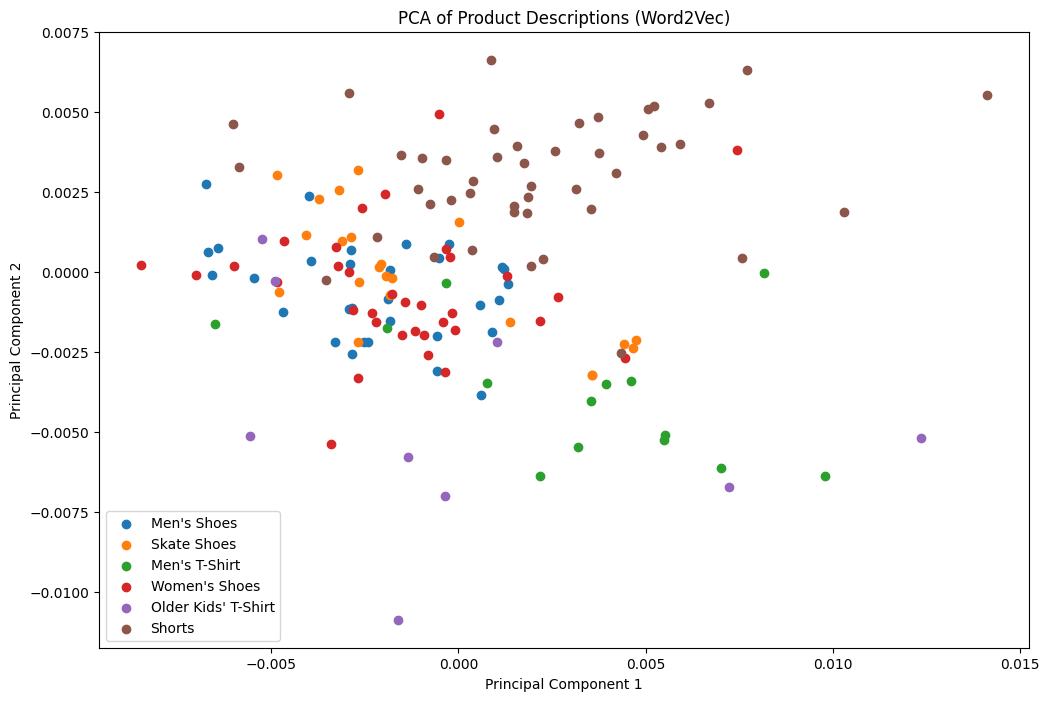

In [66]:
# Tokenize the cleaned descriptions
tokenized_descriptions = [desc.split() for desc in df_filtered['cleaned_description']]

# Train the Word2Vec model
model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)

# Word2Vec only gives us the embedding for each word, we need to calculate the average for the whole description
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

vocabulary = set(model.wv.index_to_key)
num_features = 100
product_vectors = []

# Generate the average embedding vector for each description.
for description in tokenized_descriptions:
  product_vectors.append(average_word_vectors(description, model, vocabulary, num_features))

product_vectors = np.array(product_vectors)

# Reduce the dimentionality using PCA
pca = PCA(n_components=2)
pca_result_w2v = pca.fit_transform(product_vectors)

# Create a scatter plot of the PCA results, colored by 'Subtitle'
plt.figure(figsize=(12, 8))
for subtitle in df_filtered['Subtitle'].unique():
    subset = pca_result_w2v[df_filtered['Subtitle'] == subtitle]
    plt.scatter(subset[:, 0], subset[:, 1], label=subtitle)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Product Descriptions (Word2Vec)")
plt.legend()
plt.show()


# GloVe

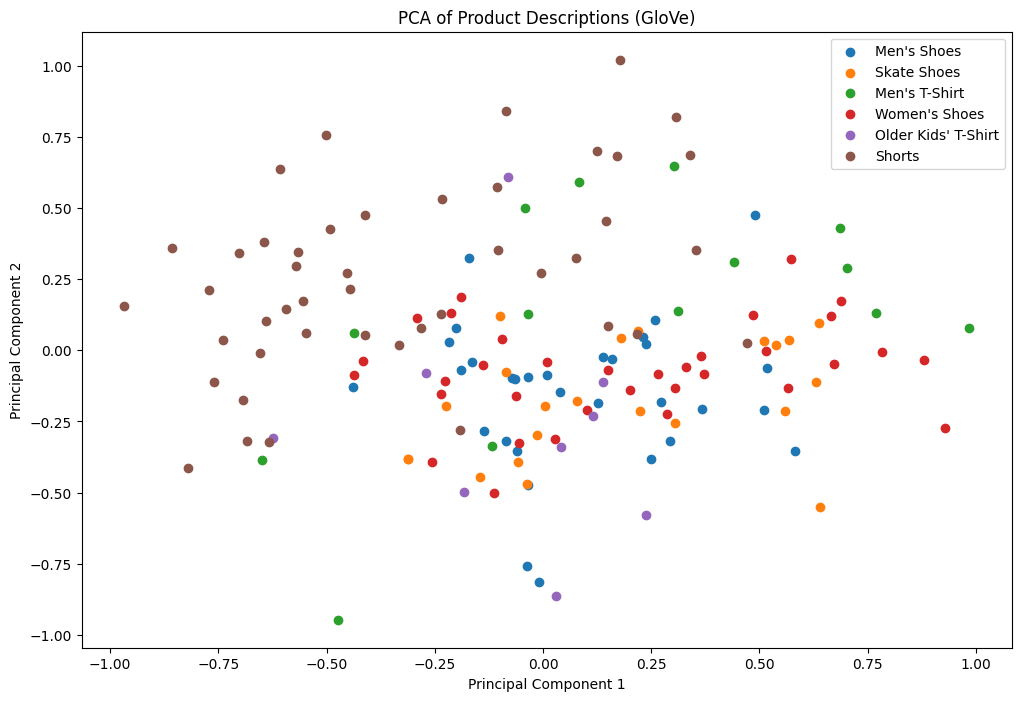

In [67]:

# Load the GloVe model (this might take some time on the first run)
glove_model = api.load("glove-wiki-gigaword-100")

# We need to average the embedding vectors, to get a single one representing the whole description.
def average_glove_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

vocabulary = set(glove_model.key_to_index)
num_features = 100
product_vectors_glove = []

for description in tokenized_descriptions:
    product_vectors_glove.append(average_glove_vectors(description, glove_model, vocabulary, num_features))

product_vectors_glove = np.array(product_vectors_glove)

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca_result_glove = pca.fit_transform(product_vectors_glove)

# Create a scatter plot of the PCA results, colored by 'Subtitle'
plt.figure(figsize=(12, 8))
for subtitle in df_filtered['Subtitle'].unique():
    subset = pca_result_glove[df_filtered['Subtitle'] == subtitle]
    plt.scatter(subset[:, 0], subset[:, 1], label=subtitle)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Product Descriptions (GloVe)")
plt.legend()
plt.show()


 # Analysis

Comparing the different embedding methods requires analyzing them from different angles (Simplicity, ability to capture semantic meaning, Compute Speed, costs...)

For this case, assuming the task at hand is to "Cluster" the products based on their description, BOW and TF-IDF have done a good job based on the PCA plots. Meaning we do not have to go to more complex and resource heavy methods like Word2Vec and GloVe.

However, we should keep in mind that the method used in this exercise is not exactly the ideal use of Word2Vec and GloVe. Since we are averaging the embedding vectors, a lot of information are lost than if we keep the individual word embeddings and use them as is. This would be ideal if we are training a complex neural network to classify the product based on its description for example.


# Conclusion

Based on the PCA plots, BOW and TF-IDF represent our data well if our main concern is the product description's relationship to the product subtitle.